In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator,ClassifierMixin
from abc import ABC, abstractmethod,abstractstaticmethod
from scipy.special import expit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
import pandas as pd

# Funções de Plot

In [2]:
def plotdataset(X,y):
    plt.xlabel('X1')
    plt.ylabel('X2')
    for k in set(y):
        plt.plot(X[:,0][y == k],X[:,1][y==k],'o',alpha=0.3)

In [3]:
def plothiperplano(X,y,vetor,intercept=0):
    X0min = min(X[:,0])
    X0max = max(X[:,0])
    xs = np.linspace(X0min,X0max,num = 2)
    ys = (-vetor[0]/vetor[1]) * xs-intercept/vetor[1]
    plt.plot(xs,ys)

# Funções de custo

In [4]:
def sign(a):
  return (a >=0)*2-1

In [5]:
class custo(ABC):
  @abstractstaticmethod
  def custo(y,ypred):
    pass
  @abstractstaticmethod
  def gradiente(y,ypred):
    pass

In [6]:
class WidrowHoff(custo):
  @staticmethod
  def custo(y,ypred):
    return np.sum((y-ypred)**2)
  @staticmethod
  def gradiente(y,ypred):
    return y-ypred

In [7]:
class SmoothedSurrogate(custo):
  @staticmethod
  def custo(y,ypred):
    return np.sum(np.maximum(np.zeros(y.shape),-y*ypred))

  @staticmethod
  def gradiente(y,ypred):
    return y-sign(ypred)

In [8]:
class Hingeloss(custo):
  @staticmethod
  def custo(y,ypred):
    return np.sum(np.maximum(np.zeros(y.shape),1-y*ypred))
  
  @staticmethod
  def gradiente(y,ypred):
    errormarginais = (y*ypred) < 1
    ymarginais = np.copy(y)
    ymarginais[~errormarginais] = 0
    return ymarginais

In [9]:
class loglikehood(custo):
  @staticmethod
  def custo(y,ypred):
    return np.sum(np.log(1+np.exp(-y*ypred)))
  @staticmethod
  def gradiente(y,ypred):
    return y-(expit(ypred)*2-1)

# Definições do Perceptron

In [102]:
class Perceptron(ClassifierMixin,BaseEstimator):
  def __init__(self,training_algorithm):
    self.w = None
    self.activation = sign
    self.training_algorithm = training_algorithm
    self.bias = training_algorithm.threshold

  @staticmethod
  def includebias(X,vs):
    bias = np.full((Xtr.shape[0],1),vs,dtype=int)
    #np.ones((X.shape[0],1))
    Xb = np.concatenate((bias,X),axis=1)
    return Xb

  def fit(self,X,y):
    yhot = self.encode_labels(y)
    Xb = Perceptron.includebias(X,self.bias)
    self.w = self.training_algorithm.getW(Xb,yhot)
    
  def __pre_activation(self,X):
      X = Perceptron.includebias(X,self.bias)
      return X @ self.w

  def predict(self,X,y=None):
      a = self.__pre_activation(X)
      if self.w.shape[1] == 1:
        idx = np.array(a > 0,dtype=int).reshape((-1,))
      else:
        idx = np.argmax(a,axis=1)
      ypred = np.array([self.labels[i] for i in idx])
      return ypred

  def encode_labels(self,y):
    self.labels = list(set(y))
    return label_binarize(y,classes=self.labels)*2-1

In [16]:
class trainingalgorithm(ABC):
  @abstractmethod
  def getW(self,X,y):
    pass

In [95]:
class DescidaGradiente(trainingalgorithm):
  def __init__(self,max_iter=2000,learning_rate=0.01,regularization=0,cost=WidrowHoff(),threshold=1):
    self.max_iter = max_iter
    self.learning_rate = learning_rate
    self.regularization = regularization
    self.cost = cost
    self.threshold = threshold
    self.custobatch = []

  def getW(self,X,y):
    w = np.random.uniform(-1,1,size=(X.shape[1],y.shape[1]))
    #forma batch de encontrar os erros
    for j in range(self.max_iter):
      ypred = X @ w
      custo = self.cost.custo(y,ypred)
      self.custobatch.append(custo)
      if custo == 0:
        break
      w *= 1-self.learning_rate*self.regularization
      w += (X.T @ self.cost.gradiente(y,ypred)) * self.learning_rate 

    return w

In [139]:
def predicaoRN(lr,th=1):
  custos = [loglikehood(),Hingeloss()]
  for i in custos:
    print(type(i).__name__)
    descida = DescidaGradiente(cost=i,learning_rate=lr,threshold=th)
    perceptron = Perceptron(descida)
    perceptron.fit(Xtr,ytr)
    ypred = perceptron.predict(Xtr)
    print(sum(ypred == ytr)/len(ytr))
    plotdataset(Xtr,ytr)
    #print(descida.custobatch)
    for i in range(perceptron.w.shape[1]):
      plothiperplano(Xtr,ytr,perceptron.w[1:,i],perceptron.w[0,i])
    plt.show()
    plt.plot(descida.custobatch)
    plt.show()

# Predição Multiclasse dataset Iris

In [121]:
from sklearn import datasets
iris = datasets.load_iris()
Xm = iris.data
ym = iris.target
Xtr,Xte,ytr,yte = train_test_split(Xm,ym,test_size=0.90)

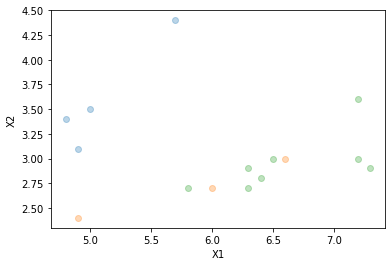

In [122]:
plotdataset(Xtr,ytr)

loglikehood
0.9333333333333333


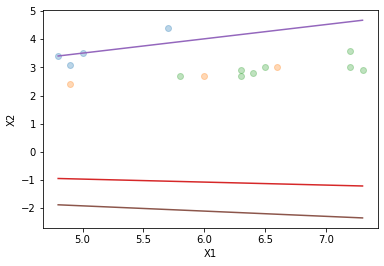

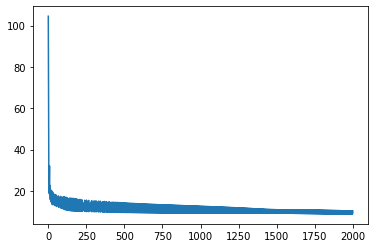

Hingeloss
0.8666666666666667


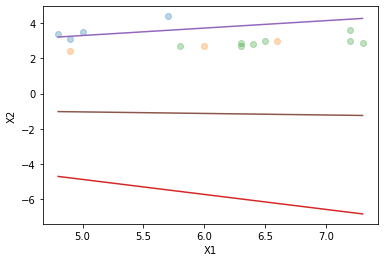

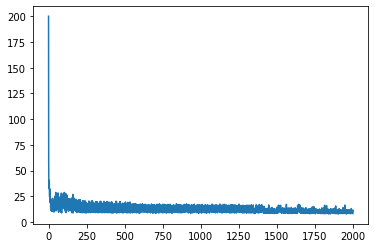

In [141]:
predicaoRN(0.009,1)

# Predição dataset binário

In [142]:
def criadatasetbinary(n=200):
  X = np.random.uniform(size=(n,2))
  y = np.array(X[:,0] > X[:,1],dtype=int)* 2-1
  return X,y

In [143]:
Xm,ym = criadatasetbinary(n=1000)
Xtr,Xte,ytr,yte = train_test_split(Xm,ym,test_size=0.90)

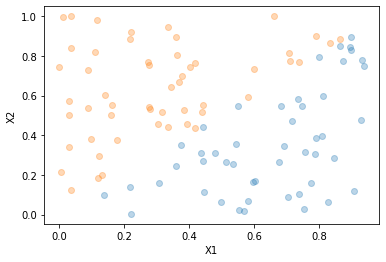

In [144]:
plotdataset(Xtr,ytr)

loglikehood
1.0


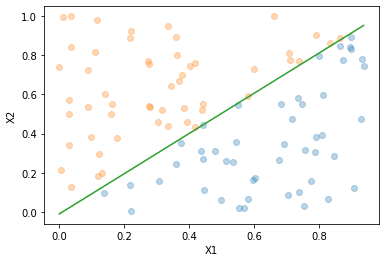

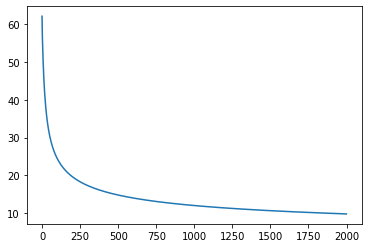

Hingeloss
1.0


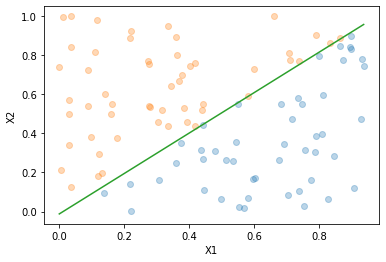

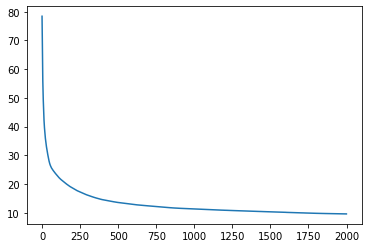

In [145]:
predicaoRN(0.01,1)